In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow import keras 
import os 
import math 
import random 
import pickle 
import glob
import matplotlib.pyplot as plt 
from collections import deque 
from tensorflow.keras import layers
import time 

from vehicle_model_DDPG1 import Environment 
from cell_model import CellModel 
from driver_MDP import Driver_MDP 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
drving_cycle = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
battery_path = "../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_nimh_6_240_panasonic_MY01_Prius.mat"
motor_path = "../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_pm_95_145_X2.mat"
cell_model = CellModel()
# env = Environment(cell_model, drving_cycle, battery_path, motor_path, 10)
driver = Driver_MDP(0.02)

num_states = 4

In [3]:
class OUActionNoise: 
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None): 
        self.theta = theta 
        self.mean = mean 
        self.std_dev = std_deviation 
        self.dt = dt 
        self.x_initial = x_initial 
        self.reset() 
        
    def reset(self): 
        if self.x_initial is not None: 
            self.x_prev = self.x_initial 
        else: 
            self.x_prev = 0 
            
    def __call__(self): 
        x = (
             self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt 
            + self.std_dev * np.sqrt(self.dt) * np.random.normal() 
        )
        self.x_prev = x 
        return x 

In [4]:
class Buffer: 
    def __init__(self, buffer_capacity=100000, batch_size=64):      
        self.buffer_capacity = buffer_capacity 
        self.batch_size = batch_size 
        self.buffer_counter = 0 
        
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, 1))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity 

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        
        self.buffer_counter += 1 
        
    def learn(self): 
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        
        with tf.GradientTape() as tape: 
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.square(y - critic_value)) 
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables) 
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )
        
        with tf.GradientTape() as tape: 
            actions = actor_model(state_batch)
            critic_value = critic_model([state_batch, actions])
            actor_loss = - tf.math.reduce_mean(critic_value)
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables) 
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        

In [5]:
def update_target(tau): 
    new_weights = [] 
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_critic.set_weights(new_weights)
    
    new_weights = [] 
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_actor.set_weights(new_weights)
    

In [6]:
def get_actor(): 
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    inputs = layers.Input(shape=(num_states))
    inputs_batchnorm = layers.BatchNormalization()(inputs)
    
    out = layers.Dense(512, activation="relu")(inputs_batchnorm)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="sigmoid", 
                          kernel_initializer=last_init)(out)
    model = tf.keras.Model(inputs, outputs)
    return model

In [7]:
def get_critic(): 
    state_input = layers.Input(shape=(num_states))
    state_input_batchnorm = layers.BatchNormalization()(state_input)
    
    state_out = layers.Dense(16, activation="relu")(state_input_batchnorm)
#     state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="relu")(state_out)
#     state_out = layers.BatchNormalization()(state_out)
    
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="relu")(action_input)
#     action_out = layers.BatchNormalization()(action_out)
    
    concat = layers.Concatenate()([state_out, action_out]) 
    
    out = layers.Dense(512, activation="relu")(concat)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)
    
    model = tf.keras.Model([state_input, action_input], outputs)
    return model 
    

In [8]:
def policy(state, noise_object): 
    j_min = state[0][2].numpy()
    j_max = state[0][3].numpy()
    sampled_action = tf.squeeze(actor_model(state)) 
    noise = noise_object()
    sampled_action = sampled_action.numpy() + noise 
    legal_action = sampled_action * j_max 
    legal_action = np.clip(legal_action, j_min, j_max)
#     print(j_min, j_max, legal_action, noise)
    return legal_action 
    

In [9]:
def policy_epsilon_greedy(state, eps): 
    j_min = state[0][-2].numpy()
    j_max = state[0][-1].numpy()

    if random.random() < eps: 
        a = random.randint(0, 9)
        return np.linspace(j_min, j_max, 10)[a]
    else: 
        sampled_action = tf.squeeze(actor_model(state)).numpy()  
        legal_action = sampled_action * j_max 
        legal_action = np.clip(legal_action, j_min, j_max)
        return legal_action

In [17]:
std_dev = 0.2 
ou_noise = OUActionNoise(mean=0, std_deviation=0.2)

critic_lr = 0.0005 
actor_lr = 0.00025 
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 300
gamma = 0.95 
tau = 0.001 

MAX_EPSILON = 0.3 
MIN_EPSILON = 0.01 
DECAY_RATE = 0.00002
BATCH_SIZE = 32 
DELAY_TRAINING = 1000 

In [18]:
def initialization(): 
    actor_model = get_actor() 
    critic_model = get_critic() 
    target_actor = get_actor() 
    target_critic = get_critic() 
#     target_actor.set_weights(actor_model.get_weights())
#     target_critic.set_weights(critic_model.get_weights())
    actor_model.load_weights("./DDPG1_trial1/actor_model_checkpoint")
    critic_model.load_weights("./DDPG1_trial1/critic_model_checkpoint")
    target_actor.load_weights("./DDPG1_trial1/target_actor_checkpoint")
    target_critic.load_weights("./DDPG1_trial1/target_critic_checkpoint")
    
    buffer = Buffer(500000, BATCH_SIZE)
    return actor_model, critic_model, target_actor, target_critic, buffer

In [19]:
def save_weights(actor_model, critic_model, target_actor, target_critic, root): 
    actor_model.save_weights("./{}/actor_model_checkpoint".format(root))
    critic_model.save_weights("./{}/critic_model_checkpoint".format(root))
    target_actor.save_weights("./{}/target_actor_checkpoint".format(root))
    target_critic.save_weights("./{}/target_critic_checkpoint".format(root))
    print("model is saved..")

In [20]:
def initialization_env(driving_path, reward_factor):
    env = Environment(cell_model, driving_path, battery_path, motor_path, reward_factor)
    return env 

In [21]:
def test_agent(actor_model, reward_factor):
    test_cycle = driver.get_cycle() 
    env = initialization_env(test_cycle, reward_factor)
    
    total_reward = 0
    state = env.reset() 
    while True: 
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = policy_epsilon_greedy(tf_state, -1)
        next_state, reward, done = env.step(action)
        
        state = next_state 
        total_reward += reward 
        
        if done: 
            break 
        
    SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
    
    print("******************* Test is start *****************")
#     print(test_cycle)
    print('Total reward: {}'.format(total_reward), 
          "SOC: {:.4f}".format(env.SOC), 
          "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
          "Fuel Consumption: {:.4f}".format(env.fuel_consumption))
    print("******************* Test is done *****************")
    print("")
    plt.plot(test_cycle)
    plt.show() 
    return env.history  
    


Trial 0


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

SOC is nan...
elapsed_time: 4.477
Episode: 1 Exploration P: 0.3000 Total reward: -10290.666836992097 SOC: nan Cumulative_SOC_deviation: nan Fuel Consumption: 14.7878


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtyp

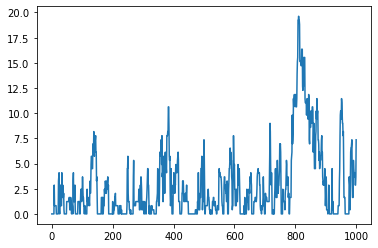

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver\vehicle_model_DDPG1.py:252: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver\vehicle_model_DDPG1.py:278: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (


SOC is nan...
elapsed_time: 7.701
Episode: 11 Exploration P: 0.2626 Total reward: -10043.40277836362 SOC: nan Cumulative_SOC_deviation: nan Fuel Consumption: 4.8846



C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver\vehicle_model_DDPG1.py:253: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver\vehicle_model_DDPG1.py:279: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


SOC is nan...
elapsed_time: 5.476
Episode: 12 Exploration P: 0.2621 Total reward: -10017.567762335742 SOC: nan Cumulative_SOC_deviation: nan Fuel Consumption: 3.4413

maximum steps, simulation is done ... 
elapsed_time: 54.140
Episode: 13 Exploration P: 0.2571 Total reward: -1505.1737063692606 SOC: 0.8560 Cumulative_SOC_deviation: 147.0842 Fuel Consumption: 34.3322

maximum steps, simulation is done ... 
elapsed_time: 54.674
Episode: 14 Exploration P: 0.2522 Total reward: -1171.618397005591 SOC: 0.8141 Cumulative_SOC_deviation: 114.1805 Fuel Consumption: 29.8130

maximum steps, simulation is done ... 
elapsed_time: 54.489
Episode: 15 Exploration P: 0.2474 Total reward: -839.4380743793766 SOC: 0.7479 Cumulative_SOC_deviation: 80.9413 Fuel Consumption: 30.0246

maximum steps, simulation is done ... 
elapsed_time: 54.416
Episode: 16 Exploration P: 0.2427 Total reward: -1062.4832100100034 SOC: 0.7883 Cumulative_SOC_deviation: 103.0412 Fuel Consumption: 32.0711

SOC is nan...
elapsed_time: 

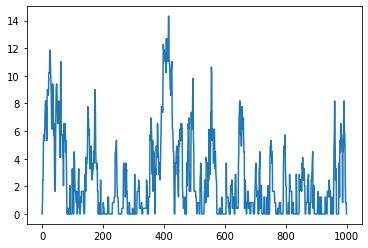

maximum steps, simulation is done ... 
elapsed_time: 54.771
Episode: 21 Exploration P: 0.2259 Total reward: -1185.9051732808584 SOC: 0.8141 Cumulative_SOC_deviation: 115.9304 Fuel Consumption: 26.6010



C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver\vehicle_model_DDPG1.py:252: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver\vehicle_model_DDPG1.py:253: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver\vehicle_model_DDPG1.py:278: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MD

SOC is nan...
elapsed_time: 33.420
Episode: 22 Exploration P: 0.2233 Total reward: -10454.42659591216 SOC: nan Cumulative_SOC_deviation: nan Fuel Consumption: 19.4679

SOC is nan...
elapsed_time: 14.506
Episode: 23 Exploration P: 0.2222 Total reward: -10105.394633717317 SOC: nan Cumulative_SOC_deviation: nan Fuel Consumption: 7.1365

maximum steps, simulation is done ... 
elapsed_time: 51.985
Episode: 24 Exploration P: 0.2180 Total reward: -1016.4830831794094 SOC: 0.8018 Cumulative_SOC_deviation: 99.0896 Fuel Consumption: 25.5868

SOC is nan...
elapsed_time: 37.477
Episode: 25 Exploration P: 0.2147 Total reward: -10738.507686736782 SOC: nan Cumulative_SOC_deviation: nan Fuel Consumption: 22.2652

maximum steps, simulation is done ... 
elapsed_time: 48.172
Episode: 26 Exploration P: 0.2107 Total reward: -1061.775186035647 SOC: 0.8427 Cumulative_SOC_deviation: 103.2531 Fuel Consumption: 29.2441

SOC is nan...
elapsed_time: 23.713
Episode: 27 Exploration P: 0.2089 Total reward: -10316.872

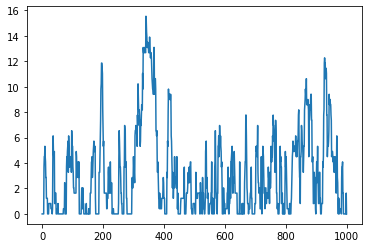

maximum steps, simulation is done ... 
elapsed_time: 47.550
Episode: 31 Exploration P: 0.1958 Total reward: -1118.9203321188168 SOC: 0.8173 Cumulative_SOC_deviation: 109.2133 Fuel Consumption: 26.7877



C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver\vehicle_model_DDPG1.py:252: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver\vehicle_model_DDPG1.py:253: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver\vehicle_model_DDPG1.py:278: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MD

SOC is nan...
elapsed_time: 44.923
Episode: 32 Exploration P: 0.1923 Total reward: -10962.38911466821 SOC: nan Cumulative_SOC_deviation: nan Fuel Consumption: 26.4774

maximum steps, simulation is done ... 
elapsed_time: 47.836
Episode: 33 Exploration P: 0.1887 Total reward: -953.4915536941007 SOC: 0.7654 Cumulative_SOC_deviation: 92.8769 Fuel Consumption: 24.7228

SOC is nan...
elapsed_time: 30.522
Episode: 34 Exploration P: 0.1867 Total reward: -10364.633938280167 SOC: nan Cumulative_SOC_deviation: nan Fuel Consumption: 13.2270

maximum steps, simulation is done ... 
elapsed_time: 52.946
Episode: 35 Exploration P: 0.1832 Total reward: -750.4487565950234 SOC: 0.7352 Cumulative_SOC_deviation: 72.7711 Fuel Consumption: 22.7382

SOC is nan...
elapsed_time: 35.811
Episode: 36 Exploration P: 0.1806 Total reward: -10472.053493846932 SOC: nan Cumulative_SOC_deviation: nan Fuel Consumption: 16.8869

maximum steps, simulation is done ... 
elapsed_time: 47.599
Episode: 37 Exploration P: 0.1772 

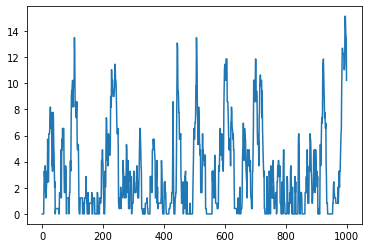

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver\vehicle_model_DDPG1.py:252: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver\vehicle_model_DDPG1.py:253: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver\vehicle_model_DDPG1.py:278: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MD

SOC is nan...
elapsed_time: 11.644
Episode: 41 Exploration P: 0.1707 Total reward: -10023.683133460912 SOC: nan Cumulative_SOC_deviation: nan Fuel Consumption: 8.9289

maximum steps, simulation is done ... 
elapsed_time: 51.925
Episode: 42 Exploration P: 0.1675 Total reward: -594.9411145671734 SOC: 0.7096 Cumulative_SOC_deviation: 57.5181 Fuel Consumption: 19.7603

SOC is nan...
elapsed_time: 21.284
Episode: 43 Exploration P: 0.1662 Total reward: -10156.551589615803 SOC: nan Cumulative_SOC_deviation: nan Fuel Consumption: 9.3975

SOC is nan...
elapsed_time: 44.373
Episode: 44 Exploration P: 0.1634 Total reward: -10543.987678623422 SOC: nan Cumulative_SOC_deviation: nan Fuel Consumption: 20.0164

SOC is nan...
elapsed_time: 44.660
Episode: 45 Exploration P: 0.1606 Total reward: -10900.34431975116 SOC: nan Cumulative_SOC_deviation: nan Fuel Consumption: 20.6667

SOC is nan...
elapsed_time: 12.938
Episode: 46 Exploration P: 0.1598 Total reward: -10067.058127139 SOC: nan Cumulative_SOC_dev

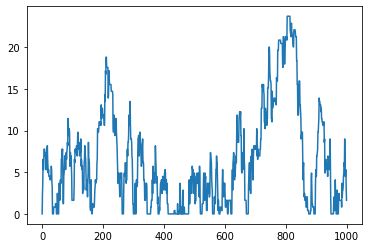

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver\vehicle_model_DDPG1.py:252: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver\vehicle_model_DDPG1.py:253: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver\vehicle_model_DDPG1.py:278: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MD

SOC is nan...
elapsed_time: 39.326
Episode: 51 Exploration P: 0.1467 Total reward: -10358.334436457486 SOC: nan Cumulative_SOC_deviation: nan Fuel Consumption: 15.1325

SOC is nan...
elapsed_time: 31.267
Episode: 52 Exploration P: 0.1451 Total reward: -10219.634612371328 SOC: nan Cumulative_SOC_deviation: nan Fuel Consumption: 12.4079

maximum steps, simulation is done ... 
elapsed_time: 59.061
Episode: 53 Exploration P: 0.1425 Total reward: -743.526682754766 SOC: 0.7516 Cumulative_SOC_deviation: 72.2040 Fuel Consumption: 21.4871

maximum steps, simulation is done ... 
elapsed_time: 54.277
Episode: 54 Exploration P: 0.1398 Total reward: -499.3859543956405 SOC: 0.6729 Cumulative_SOC_deviation: 48.4251 Fuel Consumption: 15.1349

SOC is nan...
elapsed_time: 40.563
Episode: 55 Exploration P: 0.1379 Total reward: -10513.58232868723 SOC: nan Cumulative_SOC_deviation: nan Fuel Consumption: 16.0454

Available condition is not avail... SOC: 0.5966495776238072
elapsed_time: 7.734
Episode: 56 Exp

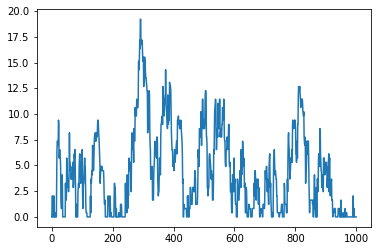

C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver\vehicle_model_DDPG1.py:252: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\ValueCreatorSong\Desktop\Academic\graduate_paper\degradation_model\experiment\generalization_MDP_driver\vehicle_model_DDPG1.py:253: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 54.483
Episode: 61 Exploration P: 0.1267 Total reward: -329.2593014143407 SOC: 0.6283 Cumulative_SOC_deviation: 31.0291 Fuel Consumption: 18.9685

maximum steps, simulation is done ... 
elapsed_time: 54.360
Episode: 62 Exploration P: 0.1244 Total reward: -727.9605736027315 SOC: 0.7256 Cumulative_SOC_deviation: 71.1748 Fuel Consumption: 16.2123

maximum steps, simulation is done ... 
elapsed_time: 59.293
Episode: 63 Exploration P: 0.1221 Total reward: -420.72818255123616 SOC: 0.7014 Cumulative_SOC_deviation: 40.0701 Fuel Consumption: 20.0275

maximum steps, simulation is done ... 
elapsed_time: 69.329
Episode: 64 Exploration P: 0.1199 Total reward: -832.3132596275346 SOC: 0.7259 Cumulative_SOC_deviation: 81.4912 Fuel Consumption: 17.4017

maximum steps, simulation is done ... 
elapsed_time: 58.431
Episode: 65 Exploration P: 0.1177 Total reward: -471.5419606461194 SOC: 0.7031 Cumulative_SOC_deviation: 45.4244 Fuel Consumption: 17.2982


In [ ]:
# print(env.version)

num_trials = 1
results_dict = {} 
# driving_cycle_paths = glob.glob("../data/driving_cycles/city/*.mat")[:1]

for trial in range(num_trials): 
    print("")
    print("Trial {}".format(trial))
    print("")
    
    actor_model, critic_model, target_actor, target_critic, buffer = initialization()
    
    eps = MAX_EPSILON 
    steps = 0
    
    episode_rewards = [] 
    episode_SOCs = [] 
    episode_FCs = [] 
    episode_test_history = [] 
    episode_num_test = [] 
    for ep in range(total_episodes): 
#         driving_cycle_path = np.random.choice(driving_cycle_paths)
#         print(driving_cycle_path)
        driving_cycle = driver.get_cycle() 
        env = initialization_env(driving_cycle, 10)
        
        start = time.time() 
        state = env.reset() 
        episodic_reward = 0 

        while True: 
            tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
            action = policy_epsilon_greedy(tf_state, eps)
    #         print(action)
            next_state, reward, done = env.step(action)
            if done: 
                next_state = [0] * num_states 

            buffer.record((state, action, reward, next_state))
            episodic_reward += reward 

            if steps > DELAY_TRAINING: 
                buffer.learn() 
                update_target(tau)
                eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * (steps
                                                                        -DELAY_TRAINING))

            steps += 1

            if done: 
                break 

            state = next_state 

        elapsed_time = time.time() - start 
        print("elapsed_time: {:.3f}".format(elapsed_time))
        episode_rewards.append(episodic_reward) 
        episode_SOCs.append(env.SOC)
        episode_FCs.append(env.fuel_consumption) 

    #     print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
        SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
        print(
              'Episode: {}'.format(ep + 1),
              "Exploration P: {:.4f}".format(eps),
              'Total reward: {}'.format(episodic_reward), 
              "SOC: {:.4f}".format(env.SOC), 
              "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
              "Fuel Consumption: {:.4f}".format(env.fuel_consumption), 
        )
        print("")
        
        if (ep + 1) % 10 == 0: 
            history = test_agent(actor_model, 10)
            episode_test_history.append(history) 
            episode_num_test.append(ep + 1)
            
    root = "DDPG1_trial{}".format(trial+1)
    save_weights(actor_model, critic_model, target_actor, target_critic, root)
    
    results_dict[trial + 1] = {
        "rewards": episode_rewards, 
        "SOCs": episode_SOCs, 
        "FCs": episode_FCs, 
        "test_history": episode_test_history, 
        "test_episode_num": episode_num_test, 
    }

In [ ]:
with open("DDPG1.pkl", "wb") as f: 
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# results_dict